In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import mlflow
import json
import pickle


In [3]:
df=pd.read_csv('final_data2.csv') # Load the dataset

In [4]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for scaling, excluding the target column 'delay'

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns.remove('delay')
scaler = StandardScaler() # Scale numerical features using StandardScaler
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Define features and target variable
X = df.drop(columns=['delay'])  # Drop the target column
y = df['delay']                 # Target variable(delay)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
X_test

,truck_age,load_capacity_pounds,mileage_mpg,age,experience,ratings,average_speed_mph,distance,average_hours,temp,...,city_description_y_Patchy light rain,city_description_y_Patchy light rain with thunder,city_description_y_Patchy light snow,city_description_y_Patchy moderate snow,city_description_y_Patchy rain possible,city_description_y_Patchy sleet possible,city_description_y_Patchy snow possible,city_description_y_Sunny,city_description_y_Thundery outbreaks possible,city_description_y_Torrential rain shower
8466,0.251230,0.267638,-1.028040,0.897772,1.305761,0.169788,1.060545,0.860703,0.860709,-1.160028,...,False,False,False,False,False,False,False,False,False,False
1399,-1.255586,-0.824204,-0.479668,1.532680,0.292402,0.169788,0.283705,-0.292101,-0.292012,0.236513,...,False,False,False,False,False,False,False,False,False,False
4635,-0.753314,1.177507,1.439634,-1.430221,-0.720957,-1.227717,1.397996,0.339014,0.338617,0.133066,...,False,False,False,False,False,False,False,False,False,False
6641,-0.251042,-1.006178,0.342890,-1.006950,-1.155253,-1.693552,0.971496,0.515977,0.515726,1.426159,...,False,False,False,False,False,False,False,False,False,False
3921,1.255774,1.177507,-0.753854,0.051229,-0.141894,-0.761882,-2.133521,0.189445,0.189150,-2.504845,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,1.255774,1.177507,-1.850598,1.321044,0.002871,-0.761882,0.569601,0.719374,0.719452,-1.832437,...,False,False,False,False,False,False,False,False,False,False
5526,-0.753314,0.267638,-0.479668,-1.430221,-0.431425,-1.693552,0.045849,-0.844449,-0.844836,-0.177277,...,False,False,False,False,False,False,False,False,False,False
2108,-0.251042,-1.006178,0.342890,-0.160407,-0.286660,-0.761882,0.380957,-0.284546,-0.284845,-0.539343,...,False,False,False,False,False,False,False,False,False,False
9804,-0.251042,-0.460257,0.068704,1.321044,1.305761,0.635622,0.559056,0.107321,0.107250,-0.229000,...,False,False,False,False,False,False,False,False,False,False


In [7]:
y_test

8466    1
1399    0
4635    1
6641    1
3921    0
       ..
4119    1
5526    0
2108    0
9804    0
4299    1
Name: delay, Length: 2522, dtype: int64

In [8]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [14]:
feature_names = X_train.columns.tolist()
with open("feature_names.json", "w") as f:
    json.dump(feature_names, f)


In [10]:
param_dist = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for splits
    'max_depth': [10, 50, 100],        # Maximum depth of the tree
    'min_samples_split': [2, 5],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],    # Minimum number of samples required at a leaf node
    'bootstrap': [True]         # Whether bootstrap samples are used when building trees
}

# Perform RandomizedSearchCV to find the best hyperparameters

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,  # Reduce CV folds
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("Truck Delay prediction")
with mlflow.start_run():
    random_search.fit(X_train, y_train)
    
    best_params = random_search.best_params_
    with open("best_params.json", "w") as f:
        json.dump(best_params, f)
        
    # Save best_model to a pickle file
    best_model = random_search.best_estimator_
    with open("best_model.pkl", "wb") as f:
        pickle.dump(best_model, f)

    mlflow.log_param("n_estimators", best_params['n_estimators'])
    mlflow.log_param("max_features",best_params['max_features'])
    mlflow.log_param("max_depth",best_params['max_depth'])
    mlflow.log_param("min_samples_split",best_params['min_samples_split'])
    mlflow.log_param("bootstrap",best_params['bootstrap'])
    mlflow.log_param("min_samples_leaf",best_params['min_samples_leaf'])



    # Evaluate the best model on test data
    y_pred = best_model.predict(X_test)
    rf_reg_accuracy = accuracy_score(y_test, y_pred)
    

    mlflow.log_metric("rf_reg_accuracy",rf_reg_accuracy)
    mlflow.sklearn.log_model(best_model,"Random Forest model") # model, foldername

2025/01/17 21:47:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [15]:
y_train_pred = best_model.predict(X_train)
y_train_pred

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [14]:
rf_reg_accuracy = accuracy_score(y_train, y_train_pred)
print(rf_reg_accuracy)

1.0


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6588
           1       1.00      1.00      1.00      3497

    accuracy                           1.00     10085
   macro avg       1.00      1.00      1.00     10085
weighted avg       1.00      1.00      1.00     10085



In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[1548  104]
 [ 354  516]]


In [21]:
df['delay'].value_counts()

delay
0    8240
1    4367
Name: count, dtype: int64

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForest model with balanced class weights
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)


In [26]:
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

[[1558   94]
 [ 365  505]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1652
           1       0.84      0.58      0.69       870

    accuracy                           0.82      2522
   macro avg       0.83      0.76      0.78      2522
weighted avg       0.82      0.82      0.81      2522



In [27]:
from sklearn.model_selection import GridSearchCV

# Define a range of class weights to try
param_grid = {'class_weight': [{0: 1, 1: w} for w in range(1, 6)]}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_rf.predict(X_test)


In [28]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1545  107]
 [ 355  515]]
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1652
           1       0.83      0.59      0.69       870

    accuracy                           0.82      2522
   macro avg       0.82      0.76      0.78      2522
weighted avg       0.82      0.82      0.81      2522



In [32]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", auc_score)


ROC AUC Score: 0.7635920236007904


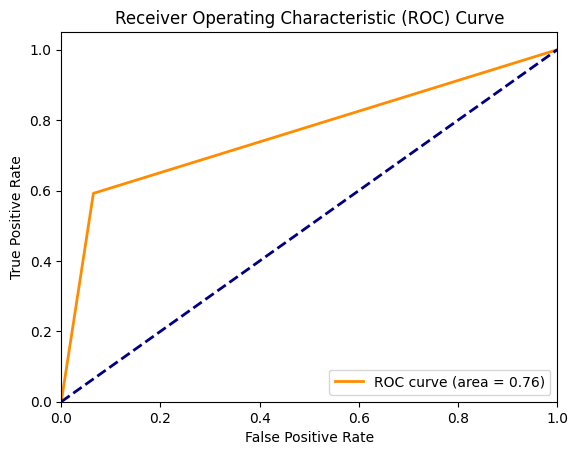

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred) # Calculate AUC roc_auc = auc(fpr, tpr)
#Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
model2 = best_model(class_weight='balanced')
model2.fit(X_train, y_train) 
y_pred3 = rf.predict(X_test)
print(classification_report(y_test,y_pred3))

TypeError: 'RandomForestClassifier' object is not callable